In [1]:
import os
import sys
import warnings
import numpy as np
from pandas import read_csv
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import traceback
import pickle

def myprint(string, clear=False):
    if clear:
        sys.stdout.write("\033[F")
        sys.stdout.write("\033[K")
    print(string)

warnings.filterwarnings("ignore")

# Tangos setup
os.environ['TANGOS_DB_CONNECTION'] = '/home/bk639/data_base/CDM_all.db'
os.environ['TANGOS_SIMULATION_FOLDER'] = '/home/bk639/data/CDM_z0'
os.environ['TANGOS_PROPERTY_MODULES'] = 'mytangosproperty'
sys.path.append('/home/bk639/mytangosproperty')
import tangos
import mytangosproperty

# Functions from original code
def sersic(r, mueff, reff, n):
    return mueff + 2.5*(0.868*n-0.142)*((r/reff)**(1./n) - 1)

def func(x, a, c, d):
    return a*np.exp(-c*x)+d

def correlation(ell, sb):
    if not isinstance(ell, np.ndarray): ell = np.array(ell)
    if not isinstance(sb, np.ndarray): sb = np.array(sb)
    n = np.nansum((ell-np.nanmean(ell)) * (sb-np.nanmean(sb)))
    d1 = np.nansum((ell-np.nanmean(ell))**2)
    d2 = np.nansum((sb-np.nanmean(sb))**2)
    return n/np.sqrt(d1*d2)

def myround(x, base=5):
    return base * round(x/base)

def randomorientation(base=30):
    phi = np.degrees(np.random.uniform(0, np.pi*2))
    y = int(myround(phi, base=base))
    theta = np.degrees(np.arccos(np.random.uniform(-1, 1)))
    x = int(myround(theta, base=base))
    if x > 165:
        x = x % 180
        y = (180-y)
        if y < 0:
            y = y + 360
    if y == 360:
        y = 0
    return(f'x{x:03d}y{y:03d}')

# Hubble parameter for mass conversion
h = 0.6776931508813172

# Initialize dictionaries to store data
SimInfo = {}
ProfData, ProjData, MorphData, ShapeData, MassData = {}, {}, {}, {}, {}
Masses = {}
nhalo = 0

# Get simulations from Tangos
sims = tangos.all_simulations()
sims = sims[0:1]
print(f"Found {len(sims)} simulations")

#load ellipse data from pickle file
with open('ellipse_data.pickle', 'rb') as f:
    ellipse_dict = pickle.load(f)


Found 1 simulations


In [62]:
ellipse_dict

{'cptmarvel.cosmo25cmb.4096g5HbwK1BH': {0: {'x000y000': array([0.16581351, 0.07908238, 0.04067977]),
   'x000y030': array([0.10504475, 0.0696568 , 0.1001042 ]),
   'x000y060': array([0.45677583, 0.4515692 , 0.3750323 ]),
   'x000y090': array([0.72427163, 0.6412875 , 0.61601028]),
   'x000y120': array([0.39326271, 0.39145749, 0.32006451]),
   'x000y150': array([0.09679613, 0.06212477, 0.04524412]),
   'x000y180': array([0.1671359 , 0.08027399, 0.03939386]),
   'x000y210': array([0.10884172, 0.06955032, 0.10534778]),
   'x000y240': array([0.45657144, 0.45155112, 0.3747331 ]),
   'x000y270': array([0.73642561, 0.64127168, 0.61567532]),
   'x000y300': array([0.39419637, 0.39144819, 0.32032337]),
   'x000y330': array([0.13468986, 0.06300607, 0.04484143]),
   'x030y000': array([0.22448541, 0.17875651, 0.16824056]),
   'x030y030': array([0.35469182, 0.31062038, 0.25430744]),
   'x030y060': array([0.54654755, 0.53298388, 0.4663473 ]),
   'x030y090': array([0.72429496, 0.64112694, 0.61638824]),

In [2]:
print(sims[0].timesteps[0].halos[0].keys())

['#ID', 'numSubStruct', 'Mvir', 'npart', 'Xc', 'Yc', 'Zc', 'VXc', 'VYc', 'VZc', 'Rvir', 'Rmax', 'r2', 'mbp_offset', 'com_offset', 'Vmax', 'v_esc', 'sigV', 'lambda', 'lambdaE', 'Lx', 'Ly', 'Lz', 'b', 'c', 'Eax', 'Eay', 'Eaz', 'Ebx', 'Eby', 'Ebz', 'Ecx', 'Ecy', 'Ecz', 'ovdens', 'nbins', 'fMhires', 'Ekin', 'Epot', 'SurfP', 'Phi0', 'cNFW', 'n_gas', 'M_gas', 'lambda_gas', 'lambdaE_gas', 'Lx_gas', 'Ly_gas', 'Lz_gas', 'b_gas', 'c_gas', 'Eax_gas', 'Eay_gas', 'Eaz_gas', 'Ebx_gas', 'Eby_gas', 'Ebz_gas', 'Ecx_gas', 'Ecy_gas', 'Ecz_gas', 'Ekin_gas', 'Epot_gas', 'n_star', 'M_star', 'lambda_star', 'lambdaE_star', 'Lx_star', 'Ly_star', 'Lz_star', 'b_star', 'c_star', 'Eax_star', 'Eay_star', 'Eaz_star', 'Ebx_star', 'Eby_star', 'Ebz_star', 'Ecx_star', 'Ecy_star', 'Ecz_star', 'Ekin_star', 'Epot_star', 'n_gas', 'n_star', 'n_dm', '#ID', 'numSubStruct', 'Mvir', 'npart', 'Xc', 'Yc', 'Zc', 'VXc', 'VYc', 'VZc', 'Rvir', 'Rmax', 'r2', 'mbp_offset', 'com_offset', 'Vmax', 'v_esc', 'sigV', 'lambda', 'lambdaE', 'Lx'

In [59]:


# Process each simulation
for sim in sims:
    sim_name = str(sim.basename)
    print(f"Processing simulation {sim_name}")

    # Initialize dictionaries for this simulation
    SimInfo[sim_name] = {'halos': [], 'goodhalos': []}
    ProfData[sim_name] = {}
    ProjData[sim_name] = {}
    MorphData[sim_name] = {}
    ShapeData[sim_name] = {}
    MassData[sim_name] = {}
    Masses[sim_name] = {}

    # Get the latest snapshot
    if len(sim.timesteps) == 1:
        timestep = sim.timesteps[0]
    else:
        timestep = sim.timesteps[-1]

    halos = timestep.halos
    halos = halos[0:20]  # Limit to the first halo for testing

    # Process each halo
    for halo in halos:
        try:
            hid = halo.halo_number
            hid_str = str(hid)

            # Check if halo has to few star particles
            if 'n_star' in halo.keys() and halo['n_star'][0] < 10000:
                #print(f"Skipping halo {hid} - too few star particles {halo['n_star'][0]}")
                continue

            print(f"Processing halo {hid}")

            # Initialize data structures for this halo
            ProfData[sim_name][hid_str] = {}
            ProjData[sim_name][hid_str] = {}
            ShapeData[sim_name][hid_str] = {}
            MorphData[sim_name][hid_str] = {}

            # Get half-light radius
            if 'Rhalf' in halo.keys():
                Rhalf = halo['Rhalf']
                # Create the face-on orientation entry if it doesn't exist
                if 'x000y000' not in ProfData[sim_name][hid_str]:
                    ProfData[sim_name][hid_str]['x000y000'] = {}
                ProfData[sim_name][hid_str]['x000y000']['Rhalf'] = Rhalf

            # Get images, orientations, and profile data
            if all(k in halo.keys() for k in ['halo_images', 'image_orientations', 'profile_sb_v', 'profile_v_lum_den',
                                             'profile_rbins', 'profile_lum_den', 'profile_mags_v', 'profile_binarea']):

                # Get the data from Tangos
                halo_images = halo['halo_images']
                image_orientations = halo['image_orientations']
                profile_sb_v = halo['profile_sb_v']
                profile_v_lum_den = halo['profile_v_lum_den']
                profile_rbins = halo['profile_rbins']
                profile_lum_den = halo['profile_lum_den']
                profile_mags_v = halo['profile_mags_v']
                profile_binarea = halo['profile_binarea']
                reff = halo['image_reffs']
                #verify all data is present
    
                    

                # Process each orientation
                for i, orientation in enumerate(image_orientations):
                    # Convert orientation angle to string format (e.g., 'x030y060')
                    #print(orientation)
                    angle_str = orientation
                    ProfData[sim_name][hid_str][angle_str] = {}

                    ProfData[sim_name][hid_str][angle_str]['sb,v'] = profile_sb_v[i]
                    ProfData[sim_name][hid_str][angle_str]['v_lum_den'] = profile_v_lum_den[i]
                    ProfData[sim_name][hid_str][angle_str]['rbins'] = profile_rbins[i]
                    ProfData[sim_name][hid_str][angle_str]['lum_den'] = profile_lum_den[i]
                    ProfData[sim_name][hid_str][angle_str]['mags,v'] = profile_mags_v[i]
                    ProfData[sim_name][hid_str][angle_str]['binarea'] = profile_binarea[i]
                    ProfData[sim_name][hid_str][angle_str]['Reff'] = reff[i]

                    # Calculate central surface brightness (Sigma0)
                    if 'mags,v' in ProfData[sim_name][hid_str][angle_str] and 'binarea' in ProfData[sim_name][hid_str][angle_str]:
                        mags_v = ProfData[sim_name][hid_str][angle_str]['mags,v']
                        binarea = ProfData[sim_name][hid_str][angle_str]['binarea']
                        if len(mags_v) > 0 and len(binarea) > 0:
                            mag0 = mags_v[0]
                            area0 = binarea[0]
                            Sigma0 = (10**(0.4*(4.8-mag0)))/area0
                            ProfData[sim_name][hid_str][angle_str]['Sigma0'] = Sigma0

            # Get ellipse data (using the 2nd element from ellipses list)
            ellipses = ellipse_dict[str(sim.basename)][int(hid_str)-1]
            #print(f"Ellipses: {ellipses}")
            # Get the orientations
            orientations = halo['image_orientations']

            # Process each orientation
            for i, orientation in enumerate(orientations):
                angle_str = orientation
                ellipse_data = ellipses[orientation][0]
                #print(f"Ellipse data for {angle_str}: {ellipse_data}")


                ProjData[sim_name][hid_str][angle_str] = {}
                ShapeData[sim_name][hid_str][angle_str] = {}

                # Store ellipse data if available for this orientation
                ProjData[sim_name][hid_str][angle_str]['b/a'] = 1 - ellipse_data
                ShapeData[sim_name][hid_str][angle_str]['b/a'] = 1 - ellipse_data

            # # Get 3D shape data
            # ba_values = halo['ba_s']
            # ca_values = halo['ca_s']
            #
            # Create smooth interpolation functions
            MorphData[sim_name][hid_str]['ba_smooth'] = halo.calculate('ba_s_smoothed()')
            MorphData[sim_name][hid_str]['ca_smooth'] = halo.calculate('ca_s_smoothed()')


            # Get mass data (applying hubble parameter)
            mass_dict = {}
            if 'Mvir' in halo.keys():
                print(f"Mass virial: {halo['Mvir']}")
                Mvir = halo['Mvir'][0]*h
                mass_dict['Mvir'] = Mvir
            if 'Mstar' in halo.keys():
                Mstar = halo['Mstar'][0]*h
                mass_dict['Mstar'] = Mstar
            if 'M_star' in halo.keys():
                M_star = halo['M_star'][0]*h
                mass_dict['Mstar'] = M_star
            if 'Mdyn' in halo.keys():
                Mdyn = halo['Mdyn'][0]
                mass_dict['Mdyn'] = Mdyn


            MassData[sim_name][hid_str] = mass_dict

            # Add halo to lists
            SimInfo[sim_name]['halos'].append(hid)
            SimInfo[sim_name]['goodhalos'].append(hid)

            # Increment halo counter
            nhalo += 1

        except Exception as e:
            print(f"Error processing halo {hid if 'hid' in locals() else 'unknown'}: {str(e)}")
            traceback.print_exc()
            

print(f"Loaded data for {nhalo} halos across {len(sims)} simulations")

Processing simulation cptmarvel.cosmo25cmb.4096g5HbwK1BH
Processing halo 1
Mass virial: [11333600000.0, 11333600000.0]
Processing halo 2
Mass virial: [7213730000.0, 7213730000.0]
Processing halo 3
Mass virial: [6385590000.0, 6385590000.0]
Processing halo 5
Mass virial: [5476310000.0, 5476310000.0]
Processing halo 6
Mass virial: [4806100000.0, 4806100000.0]
Processing halo 8
Mass virial: [53319500000.0, 53319500000.0]
Processing halo 10
Mass virial: [2543450000.0, 2543450000.0]
Loaded data for 14 halos across 1 simulations


In [3]:

# Calculate M/L ratios
for sim in SimInfo:
    for halo in ProfData[sim]:
        if halo not in MassData[sim]:
            continue

        for angle in ProfData[sim][halo]:

            # Get effective radius
            Reff = ProfData[sim][halo]['x000y000']['Reff']

            # Get magnitude and radius bins
            mags = ProfData[sim][halo][angle]['mags,v']
            rbins = ProfData[sim][halo][angle]['rbins']

            # Find index closest to Reff
            indeff = np.argmin(np.abs(Reff - rbins))

            # Calculate luminosity
            lums = 10**(0.4*(4.8-mags))
            lumeff = np.sum(lums[:indeff+1]) if indeff < len(lums) else np.sum(lums)

            # Calculate M/L
            ProfData[sim][halo][angle]['M/L'] = MassData[sim][halo]['Mdyn'] / lumeff


xu_folder = '/home/bk639/MorphologyMeasurements'
# Xu & Randall 2020 data
LGall = [-0.287, 0.058, '#7B0B01', 'All LG Dsphs']
LGbright = [-0.353, 0.059, '#FFCC99', 'LG Dsphs\n'+r'$M/L<100M_\odot/L_\odot$']
LGdim = [0.509, 0.309, '#339AFE', 'LG Dsphs\n'+r'$M/L>100M_\odot/L_\odot$']
FIRE = [-0.322, 0.213, '#411B52', 'FIRE Simulations']
FIRE_Data = read_csv(xu_folder+'/Data/BasicData/FIRE_Data.csv')
FIRE_x = FIRE_Data['X'].tolist()
FIRE_y = FIRE_Data['Y'].tolist()

# Analysis parameters
n_itr = int(1e5)
xbins = np.linspace(-1, 1, 500)
Xu = True
EnvSplit = True
Scatter = True
DimSplit = True
IndCor = True



In [4]:
# Ellipticity vs Surface Brightness plots with comparison to Xu & Randall 2020, including LG Dsphs
Xu_Dim = read_csv(xu_folder+'/Data/BasicData/Xu_Scatter_Dim.csv')
DimX = Xu_Dim['X'].tolist()
DimY = Xu_Dim['Y'].tolist()
Xu_Bright = read_csv(xu_folder+'/Data/BasicData/Xu_Scatter_Bright.csv')
BrightX = Xu_Bright['X'].tolist()
BrightY = Xu_Bright['Y'].tolist()

xbx, xby, xbxl, xbxu, xbyl, xbyu = [], [], [], [], [], []
xdx, xdy, xdxl, xdxu, xdyl, xdyu = [], [], [], [], [], []
i = 0
while i < len(DimX) - 4:
    xdx.append(DimX[i])
    xdxl.append(DimX[i] - DimX[i+1])
    xdxu.append(DimX[i+2] - DimX[i])
    xdy.append(DimY[i])
    xdyl.append(DimY[i] - DimY[i+3])
    xdyu.append(DimY[i+4] - DimY[i])
    i += 5
i = 0
while i < len(BrightX) - 4:
    xbx.append(BrightX[i])
    xbxl.append(BrightX[i] - BrightX[i+1])
    xbxu.append(BrightX[i+2] - BrightX[i])
    xby.append(BrightY[i])
    xbyl.append(BrightY[i] - BrightY[i+3])
    xbyu.append(BrightY[i+4] - BrightY[i])
    i += 5

x, y, xl, xu, yl, yu = [], [], [], [], [], []
bx, by, bxl, bxu, byl, byu = [], [], [], [], [], []
dx, dy, dxl, dxu, dyl, dyu = [], [], [], [], [], []

for sim in SimInfo:
    for halo in SimInfo[sim]['halos']:
        halo = str(halo)
        if halo not in ProfData[sim]:
            continue

        ells, sbs = [], []
        ellsb, sbsb = [], []
        ellsd, sbsd = [], []

        for angle in ProfData[sim][halo]:
            if ('b/a' not in ProjData[sim][halo][angle] or
                'Sigma0' not in ProfData[sim][halo][angle]):
                continue

            ells.append(1 - ProjData[sim][halo][angle]['b/a'])
            sbs.append(ProfData[sim][halo][angle]['Sigma0'])

            if 'x000y000' in ProfData[sim][halo] and 'M/L' in ProfData[sim][halo]['x000y000']:
                if ProfData[sim][halo]['x000y000']['M/L'] < 100:
                    ellsb.append(1 - ProjData[sim][halo][angle]['b/a'])
                    sbsb.append(ProfData[sim][halo][angle]['Sigma0'])
                else:
                    ellsd.append(1 - ProjData[sim][halo][angle]['b/a'])
                    sbsd.append(ProfData[sim][halo][angle]['Sigma0'])

        if len(ells) > 0 and len(sbs) > 0:
            x.append(np.nanmean(sbs))
            y.append(np.nanmean(ells))
            xl.append(np.nanmean(sbs) - np.min(sbs))
            xu.append(np.max(sbs) - np.nanmean(sbs))
            yl.append(np.nanmean(ells) - np.min(ells))
            yu.append(np.max(ells) - np.nanmean(ells))

            if 'x000y000' in ProfData[sim][halo] and 'M/L' in ProfData[sim][halo]['x000y000']:
                if ProfData[sim][halo]['x000y000']['M/L'] < 100 and len(ellsb) > 0:
                    bx.append(np.nanmean(sbsb))
                    by.append(np.nanmean(ellsb))
                    bxl.append(np.nanmean(sbsb) - np.min(sbsb))
                    bxu.append(np.max(sbsb) - np.nanmean(sbsb))
                    byl.append(np.nanmean(ellsb) - np.min(ellsb))
                    byu.append(np.max(ellsb) - np.nanmean(ellsb))
                elif len(ellsd) > 0:
                    dx.append(np.nanmean(sbsd))
                    dy.append(np.nanmean(ellsd))
                    dxl.append(np.nanmean(sbsd) - np.min(sbsd))
                    dxu.append(np.max(sbsd) - np.nanmean(sbsd))
                    dyl.append(np.nanmean(ellsd) - np.min(ellsd))
                    dyu.append(np.max(ellsd) - np.nanmean(ellsd))

# Generate plots
output_dir = 'CorrelationTesting/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

f, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.set_ylim([0, 1])
ax.set_xlim([2e-2, 1e3])
ax.semilogx()
ax.set_yticks([0, .2, .4, .6, .8])
ax.tick_params(which='both', labelsize=15)
ax.set_xlabel(r'Surface Brightness (L$_\odot$/pc$^2$)', fontsize=20)
ax.set_ylabel(r'Ellipticity $(1-b/a)$', fontsize=20)

ax.errorbar(xbx, xby, xerr=[xbxl, xbxu], yerr=[xbyl, xbyu], c='#FFCC99', fmt='none')
ax.scatter(xbx, xby, c='#FFCC99', label=r'LG Dsphs $M/L<100M_\odot/L_\odot$')

ax.errorbar(xdx, xdy, xerr=[xdxl, xdxu], yerr=[xdyl, xdyu], c='#339AFE', fmt='none')
ax.scatter(xdx, xdy, c='#339AFE', label=r'LG Dsphs $M/L>100M_\odot/L_\odot$')

ax.errorbar(bx, by, xerr=[bxl, bxu], yerr=[byl, byu], c='goldenrod', fmt='none', zorder=0)
ax.scatter(bx, by, c='goldenrod', zorder=1, label=r'Sim $M/L<100M_\odot/L_\odot$')

ax.errorbar(dx, dy, xerr=[dxl, dxu], yerr=[dyl, dyu], c='navy', fmt='none', zorder=0)
ax.scatter(dx, dy, c='navy', zorder=1, label=r'Sim $M/L>100M_\odot/L_\odot$')

ax.legend(loc='upper right', prop={'size': 12})
f.savefig(output_dir + 'Ell_vs_SB.png', bbox_inches='tight', pad_inches=.1)


# Plot without error bars
f, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.set_ylim([0, 1])
ax.set_xlim([2e-2, 1e3])
ax.semilogx()
ax.set_yticks([0, .2, .4, .6, .8])
ax.tick_params(which='both', labelsize=15)
ax.set_xlabel(r'Surface Brightness (L$_\odot$/pc$^2$)', fontsize=20)
ax.set_ylabel(r'Ellipticity $(1-b/a)$', fontsize=20)

ax.scatter(xbx, xby, c='#FFCC99', label=r'LG Dsphs $M/L<100M_\odot/L_\odot$')
ax.scatter(xdx, xdy, c='#339AFE', label=r'LG Dsphs $M/L>100M_\odot/L_\odot$')
ax.scatter(bx, by, c='k', zorder=1, label=r'Sim $M/L<100M_\odot/L_\odot$')
ax.scatter(dx, dy, c='r', zorder=1, label=r'Sim $M/L>100M_\odot/L_\odot$')

ax.legend(loc='upper right', prop={'size': 12})
f.savefig(output_dir+'Ell_vs_SB.NoBar.png', bbox_inches='tight', pad_inches=.1)


# Define functions for other analyses (Xu, EnvSplit, DimSplit, IndCor)
# These would follow a similar pattern to the Scatter analysis above
# Implement as needed based on which flags are set to True

print(f"Analysis complete. Total halos processed: {nhalo}")

Analysis complete. Total halos processed: 7


In [5]:
# ellipticity vs surface brightness correlation
PlotDict = ShapeData
r_dist, ind_r = np.zeros(n_itr), np.zeros(nhalo)
print('Running: 0.00%')
for n in np.arange(n_itr):
    ell, sb, i = np.zeros(nhalo), np.zeros(nhalo), 0
    for sim in ProfData:
        for halo in SimInfo[sim]['goodhalos']:
            halo = str(halo)
            angle = randomorientation()
            ell[i] = 1 - PlotDict[sim][halo][angle]['b/a']
            sb[i] = ProfData[sim][halo][angle]['Sigma0']
            if n == n_itr - 1:
                ell_ind, sb_ind, sbc_ind = [], [], []
                for a in ProfData[sim][halo]:
                    ell_ind.append(1 - PlotDict[sim][halo][a]['b/a'])
                    sb_ind.append(ProfData[sim][halo][a]['Sigma0'])
                ind_r[i] = correlation(ell_ind, sb_ind)
            i += 1

    r_dist[n] = correlation(ell, sb)
    #myprint(f'Running: {round((n + 1) / n_itr * 100, 2)}%', clear=True)

# Faceon
# ell_f,sb_f,ell_s,sb_s,i = np.zeros(nhalo),np.zeros(nhalo),np.zeros(nhalo),np.zeros(nhalo),0
# for sim in ProfData:
#     for halo in ProfData[sim]:
#         ell_f[i] = 1-PlotDict[sim][halo]['x000y000']['b/a']
#         sb_f[i] = ProfData[sim][halo]['x000y000']['Sigma0']
#         ell_s[i] = 1-PlotDict[sim][halo]['x090y000']['b/a']
#         sb_s[i] = ProfData[sim][halo]['x090y000']['Sigma0']
#         i+=1
# r_face = correlation(ell_f,sb_f)
# r_side = correlation(ell_s,sb_s)

f, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.set_xlabel(r'r$_{\epsilon\Sigma_*}$', fontsize=25)
ax.tick_params(which='both', labelsize=15)
ax.set_xlim([-1, 1])
ax.set_yticks([])
# ind_ax = ax.twiny()
# ind_ax.set_xlim([-1,1])
# ind_ax.set_xticks(np.ndarray.tolist(ind_r[np.isfinite(ind_r)]))
# ind_ax.set_xticklabels([])
# ind_ax.tick_params(axis='x',length=8,direction='in')

ax.axvspan(FIRE[0] - FIRE[1], FIRE[0] + FIRE[1], color=FIRE[2], alpha=.3)
ax.plot(FIRE_x, FIRE_y, color=FIRE[2], linewidth=2, label=FIRE[3])
ax.fill_between(FIRE_x, [0] * len(FIRE_x), FIRE_y, color=FIRE[2], alpha=.5)
for obs in [LGall, LGbright, LGdim]:
    ax.axvline(obs[0], color=obs[2], linewidth=2, label=obs[3])
    ax.axvspan(obs[0] - obs[1], obs[0] + obs[1], color=obs[2], alpha=.3)

density = stats.gaussian_kde(r_dist)
ax.plot(xbins, density(xbins), c='k', linewidth=3, label='Marvel+DCJL Simulations')
#print(xbins, density(xbins))
ax.set_ylim(bottom=0)
ax.legend(loc='upper left', prop={'size': 12})
# plt.show()
f.savefig('CorrelationTesting/Correlation.png', bbox_inches='tight', pad_inches=.1)


Running: 0.00%


In [36]:
# Ellipticity vs Surface Brightness correlation by environment
#dont forget to re-add other environments to the plot
cens, sats, bsps = [], [], []

# Create a mapping from short simulation names to full names in SimInfo
sim_name_mapping = {}
for full_name in SimInfo.keys():
    # Extract the short name (part before the first dot)
    short_name = full_name.split('.')[0]
    sim_name_mapping[short_name] = full_name

# Read both files
file_paths = [
    '/home/bk639/MorphologyMeasurements/Data/BasicData/HaloTypes.BWMDC.txt',
    '/home/bk639/MorphologyMeasurements/Data/BasicData/HaloTypes.MerianCDM.txt'
]

lines = []
for file_path in file_paths:
    with open(file_path) as f:
        lines.extend(f.readlines())

l = lines[1].split('\t')
#print(l[0], l[1], l[-2])

for line in lines:
    l = line.split('\t')
    short_sim_name = l[0]
    #print(l[0], l[1], l[-2])
    if short_sim_name in sim_name_mapping:
        full_sim_name = sim_name_mapping[short_sim_name]
        #print(f'Adding {short_sim_name} {l[1]} {l[-2]}')
        if l[-2] == 'Central' and int(l[1]) in SimInfo[full_sim_name]['goodhalos']:
            cens.append((full_sim_name, l[1]))
            print(f'Adding {full_sim_name} {l[1]} Central')
        elif l[-2] == 'Satellite' and int(l[1]) in SimInfo[full_sim_name]['goodhalos']:
            sats.append((full_sim_name, l[1]))
            print(f'Adding {full_sim_name} {l[1]} Satellite')
        elif l[-1] == 'Central' and int(l[1]) in SimInfo[full_sim_name]['goodhalos']:
            cens.append((full_sim_name, l[1]))
            print(f'Adding {full_sim_name} {l[1]} Central A')
        elif l[-1] == 'Satellite' and int(l[1]) in SimInfo[full_sim_name]['goodhalos']:
            sats.append((full_sim_name, l[1]))
            print(f'Adding {full_sim_name} {l[1]} Satellite A')


PlotDict = ShapeData
r_dist_c, r_dist_s, r_dist_b, ind_r_c, ind_r_s, ind_r_b = [np.zeros(n_itr), np.zeros(n_itr), np.zeros(n_itr),
                                                           np.zeros(len(cens)), np.zeros(len(sats)),
                                                           np.zeros(len(bsps))]
print('Running Splits: 0.00%')
for n in np.arange(n_itr):

    ell, sb, i = np.zeros(len(cens)), np.zeros(len(cens)), 0
    for halo in cens:
        angle = randomorientation()
        ell[i] = 1 - PlotDict[halo[0]][halo[1]][angle]['b/a']
        sb[i] = ProfData[halo[0]][halo[1]][angle]['Sigma0']
        if n == n_itr - 1:
            ell_ind, sb_ind, sbc_ind = [], [], []
            for a in ProfData[halo[0]][halo[1]]:
                ell_ind.append(1 - PlotDict[halo[0]][halo[1]][a]['b/a'])
                sb_ind.append(ProfData[halo[0]][halo[1]][a]['Sigma0'])
            ind_r_c[i] = correlation(ell_ind, sb_ind)
        i += 1
    #print(ell,sb)
    r_dist_c[n] = correlation(ell, sb)

    ell, sb, i = np.zeros(len(sats)), np.zeros(len(sats)), 0
    for halo in sats:
        angle = randomorientation()
        ell[i] = 1 - PlotDict[halo[0]][halo[1]][angle]['b/a']
        sb[i] = ProfData[halo[0]][halo[1]][angle]['Sigma0']
        if n == n_itr - 1:
            ell_ind, sb_ind, sbc_ind = [], [], []
            for a in ProfData[halo[0]][halo[1]]:
                ell_ind.append(1 - PlotDict[halo[0]][halo[1]][a]['b/a'])
                sb_ind.append(ProfData[halo[0]][halo[1]][a]['Sigma0'])
            ind_r_s[i] = correlation(ell_ind, sb_ind)
        i += 1
    r_dist_s[n] = correlation(ell, sb)

    ell, sb, i = np.zeros(len(bsps)), np.zeros(len(bsps)), 0
    for halo in bsps:
        angle = randomorientation()
        ell[i] = 1 - PlotDict[halo[0]][halo[1]][angle]['b/a']
        sb[i] = ProfData[halo[0]][halo[1]][angle]['Sigma0']
        if n == n_itr - 1:
            ell_ind, sb_ind, sbc_ind = [], [], []
            for a in ProfData[halo[0]][halo[1]]:
                ell_ind.append(1 - PlotDict[halo[0]][halo[1]][a]['b/a'])
                sb_ind.append(ProfData[halo[0]][halo[1]][a]['Sigma0'])
            ind_r_b[i] = correlation(ell_ind, sb_ind)
        i += 1
    r_dist_b[n] = correlation(ell, sb)

    #myprint(f'Running Splits: {round((n + 1) / n_itr * 100, 2)}%', clear=True)

print(r_dist_c)
f, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.set_xlabel(r'r$_{\epsilon\Sigma_*}$', fontsize=25)
ax.tick_params(which='both', labelsize=15)
ax.set_xlim([-1, 1])
ax.set_yticks([])
# ind_ax = ax.twiny()
# ind_ax.set_xlim([-1,1])
# ind_ax.set_xticks(np.ndarray.tolist(ind_r[np.isfinite(ind_r)]))
# ind_ax.set_xticklabels([])
# ind_ax.tick_params(axis='x',length=8,direction='in')

ax.axvspan(FIRE[0] - FIRE[1], FIRE[0] + FIRE[1], color=FIRE[2], alpha=.3)
ax.plot(FIRE_x, FIRE_y, color=FIRE[2], linewidth=2)  # ,label=FIRE[3])
ax.fill_between(FIRE_x, [0] * len(FIRE_x), FIRE_y, color=FIRE[2], alpha=.5)
for obs in [LGall, LGbright, LGdim]:
    ax.axvline(obs[0], color=obs[2], linewidth=2)  # ,label=obs[3])
    ax.axvspan(obs[0] - obs[1], obs[0] + obs[1], color=obs[2], alpha=.3)

density = stats.gaussian_kde(r_dist_c)
ax.plot(xbins, density(xbins), c='k', linewidth=3, label='Centrals')
# density = stats.gaussian_kde(r_dist_s)
# ax.plot(xbins, density(xbins), c='k', linewidth=3, linestyle='--', label='Satellites')
# density = stats.gaussian_kde(r_dist_b)
# ax.plot(xbins,density(xbins),c='k',linewidth=3,linestyle=':',label='Backsplash')

ax.set_ylim(bottom=0)
ax.legend(loc='upper left', prop={'size': 12})
# plt.show()
f.savefig('CorrelationTesting/Correlation.Subpopulations.png', bbox_inches='tight', pad_inches=.1)


Adding cptmarvel.cosmo25cmb.4096g5HbwK1BH 1 Central
Adding cptmarvel.cosmo25cmb.4096g5HbwK1BH 2 Central
Adding cptmarvel.cosmo25cmb.4096g5HbwK1BH 3 Central
Adding cptmarvel.cosmo25cmb.4096g5HbwK1BH 5 Central
Adding cptmarvel.cosmo25cmb.4096g5HbwK1BH 6 Central
Adding cptmarvel.cosmo25cmb.4096g5HbwK1BH 10 Central


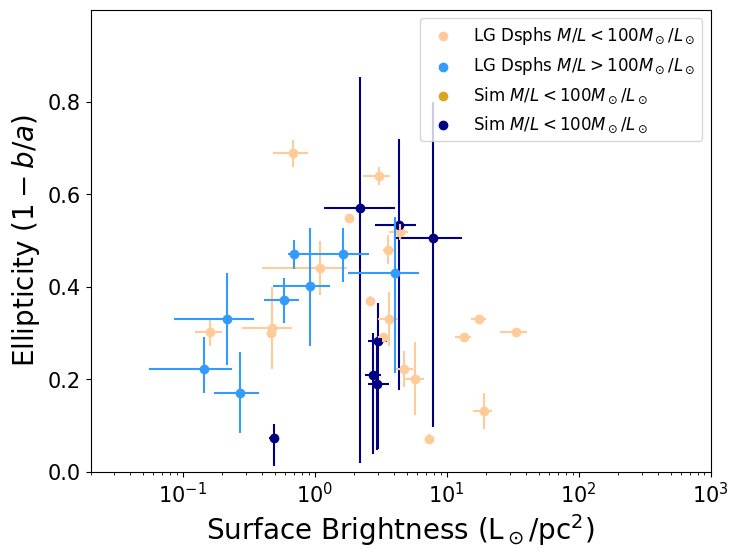

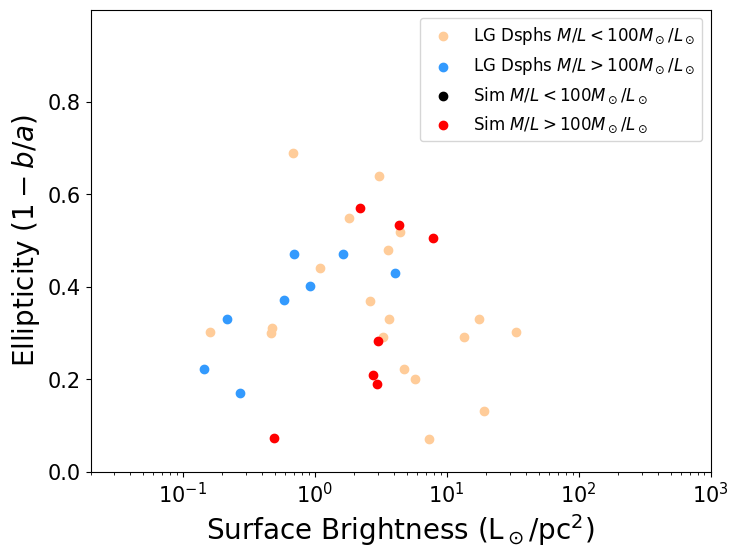

In [50]:

# Split by dim/bright
# Ellipticity vs Surface Brightness plots with comparison to Xu & Randall 2020, including LG Dsphs

Xu_Dim = read_csv(xu_folder+'/Data/BasicData/Xu_Scatter_Dim.csv')
DimX = Xu_Dim['X'].tolist()
DimY = Xu_Dim['Y'].tolist()
Xu_Bright = read_csv(xu_folder+'/Data/BasicData/Xu_Scatter_Bright.csv')
BrightX = Xu_Bright['X'].tolist()
BrightY = Xu_Bright['Y'].tolist()

xbx, xby, xbxl, xbxu, xbyl, xbyu = [], [], [], [], [], []
xdx, xdy, xdxl, xdxu, xdyl, xdyu = [], [], [], [], [], []
i = 0
while i < len(DimX) - 4:
    xdx.append(DimX[i])
    xdxl.append(DimX[i] - DimX[i + 1])
    xdxu.append(DimX[i + 2] - DimX[i])
    xdy.append(DimY[i])
    xdyl.append(DimY[i] - DimY[i + 3])
    xdyu.append(DimY[i + 4] - DimY[i])
    i += 5
i = 0
while i < len(BrightX) - 4:
    xbx.append(BrightX[i])
    xbxl.append(BrightX[i] - BrightX[i + 1])
    xbxu.append(BrightX[i + 2] - BrightX[i])
    xby.append(BrightY[i])
    xbyl.append(BrightY[i] - BrightY[i + 3])
    xbyu.append(BrightY[i + 4] - BrightY[i])
    i += 5

x, y, xl, xu, yl, yu = [], [], [], [], [], []
bx, by, bxl, bxu, byl, byu = [], [], [], [], [], []
dx, dy, dxl, dxu, dyl, dyu = [], [], [], [], [], []
for sim in SimInfo:
    for halo in SimInfo[sim]['halos']:
        halo = str(halo)
        ells, sbs = [], []
        ellsb, sbsb = [], []
        ellsd, sbsd = [], []
        for angle in ProfData[sim][halo]:
            ells.append(1 - ProjData[sim][halo][angle]['b/a'])
            sbs.append(ProfData[sim][halo][angle]['Sigma0'])
            if ProfData[sim][halo]['x000y000']['M/L'] < 100:
                ellsb.append(1 - ProjData[sim][halo][angle]['b/a'])
                sbsb.append(ProfData[sim][halo][angle]['Sigma0'])
            else:
                ellsd.append(1 - ProjData[sim][halo][angle]['b/a'])
                sbsd.append(ProfData[sim][halo][angle]['Sigma0'])
        x.append(np.nanmean(sbs))
        y.append(np.nanmean(ells))
        xl.append(np.nanmean(sbs) - np.min(sbs))
        xu.append(np.max(sbs) - np.nanmean(sbs))
        yl.append(np.nanmean(ells) - np.min(ells))
        yu.append(np.max(ells) - np.nanmean(ells))
        # print(f"{ProfData[sim][halo]['x000y000']['M/L']}")
        if ProfData[sim][halo]['x000y000']['M/L'] < 100:
            bx.append(np.nanmean(sbsb))
            by.append(np.nanmean(ellsb))
            bxl.append(np.nanmean(sbsb) - np.min(sbsb))
            bxu.append(np.max(sbsb) - np.nanmean(sbsb))
            byl.append(np.nanmean(ellsb) - np.min(ellsb))
            byu.append(np.max(ellsb) - np.nanmean(ellsb))
        else:
            dx.append(np.nanmean(sbsd))
            dy.append(np.nanmean(ellsd))
            dxl.append(np.nanmean(sbsd) - np.min(sbsd))
            dxu.append(np.max(sbsd) - np.nanmean(sbsd))
            dyl.append(np.nanmean(ellsd) - np.min(ellsd))
            dyu.append(np.max(ellsd) - np.nanmean(ellsd))

f, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.set_ylim([0, 1])
ax.set_xlim([2e-2, 1e3])
ax.semilogx()
ax.set_yticks([0, .2, .4, .6, .8])
ax.tick_params(which='both', labelsize=15)
ax.set_xlabel(r'Surface Brightness (L$_\odot$/pc$^2$)', fontsize=20)
ax.set_ylabel(r'Ellipticity $(1-b/a)$', fontsize=20)

# ax.errorbar(x,y,xerr=[xl,xu],yerr=[yl,yu],c='.7',fmt='none',zorder=0)
# ax.scatter(x,y,c='.4',zorder=1)

ax.errorbar(xbx, xby, xerr=[xbxl, xbxu], yerr=[xbyl, xbyu], c='#FFCC99', fmt='none')
ax.scatter(xbx, xby, c='#FFCC99', label=r'LG Dsphs $M/L<100M_\odot/L_\odot$')

ax.errorbar(xdx, xdy, xerr=[xdxl, xdxu], yerr=[xdyl, xdyu], c='#339AFE', fmt='none')
ax.scatter(xdx, xdy, c='#339AFE', label=r'LG Dsphs $M/L>100M_\odot/L_\odot$')

ax.errorbar(bx, by, xerr=[bxl, bxu], yerr=[byl, byu], c='goldenrod', fmt='none', zorder=0)
ax.scatter(bx, by, c='goldenrod', zorder=1, label=r'Sim $M/L<100M_\odot/L_\odot$')

ax.errorbar(dx, dy, xerr=[dxl, dxu], yerr=[dyl, dyu], c='navy', fmt='none', zorder=0)
ax.scatter(dx, dy, c='navy', zorder=1, label=r'Sim $M/L<100M_\odot/L_\odot$')

ax.legend(loc='upper right', prop={'size': 12})
f.savefig('CorrelationTesting/Ell_vs_SB.png', bbox_inches='tight', pad_inches=.1)


f, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.set_ylim([0, 1])
ax.set_xlim([2e-2, 1e3])
ax.semilogx()
ax.set_yticks([0, .2, .4, .6, .8])
ax.tick_params(which='both', labelsize=15)
ax.set_xlabel(r'Surface Brightness (L$_\odot$/pc$^2$)', fontsize=20)
ax.set_ylabel(r'Ellipticity $(1-b/a)$', fontsize=20)

# ax.errorbar(x,y,xerr=[xl,xu],yerr=[yl,yu],c='.7',fmt='none',zorder=0)
# ax.scatter(x,y,c='.4',zorder=1)

# ax.errorbar(xbx,xby,xerr=[xbxl,xbxu],yerr=[xbyl,xbyu],c='#FFCC99',fmt='none')
ax.scatter(xbx, xby, c='#FFCC99', label=r'LG Dsphs $M/L<100M_\odot/L_\odot$')

# ax.errorbar(xdx,xdy,xerr=[xdxl,xdxu],yerr=[xdyl,xdyu],c='#339AFE',fmt='none')
ax.scatter(xdx, xdy, c='#339AFE', label=r'LG Dsphs $M/L>100M_\odot/L_\odot$')

# ax.errorbar(bx,by,xerr=[bxl,bxu],yerr=[byl,byu],c='goldenrod',fmt='none',zorder=0)
ax.scatter(bx, by, c='k', zorder=1, label=r'Sim $M/L<100M_\odot/L_\odot$')

# ax.errorbar(dx,dy,xerr=[dxl,dxu],yerr=[dyl,dyu],c='navy',fmt='none',zorder=0)
ax.scatter(dx, dy, c='r', zorder=1, label=r'Sim $M/L>100M_\odot/L_\odot$')

ax.legend(loc='upper right', prop={'size': 12})
f.savefig('CorrelationTesting/Ell_vs_SB.NoBar.png', bbox_inches='tight', pad_inches=.1)


In [51]:

# Bright - Dim Split
PlotDict = ShapeData
r_dist_b, r_dist_d = np.zeros(n_itr), np.zeros(n_itr)
print('Running: 0.00%')
for n in np.arange(n_itr):
    elld, sbd, ellb, sbb = [], [], [], []
    for sim in ProfData:
        for halo in SimInfo[sim]['halos']:
            halo = str(halo)
            angle = randomorientation()
            if ProfData[sim][halo][angle]['M/L'] < 100:
                ellb.append(1 - PlotDict[sim][halo][angle]['b/a'])
                sbb.append(ProfData[sim][halo][angle]['Sigma0'])
            else:
                elld.append(1 - PlotDict[sim][halo][angle]['b/a'])
                sbd.append(ProfData[sim][halo][angle]['Sigma0'])

    r_dist_b[n] = correlation(ellb, sbb)
    r_dist_d[n] = correlation(elld, sbd)
    #myprint(f'Running: {round((n + 1) / n_itr * 100, 2)}%', clear=True)

Running: 0.00%


In [52]:
print(r_dist_d)

[0.39665327 0.64697299 0.481366   ... 0.60007582 0.7374071  0.38644831]


Bright: 0 - nan
Dim: 7 - 0.5930646864163233


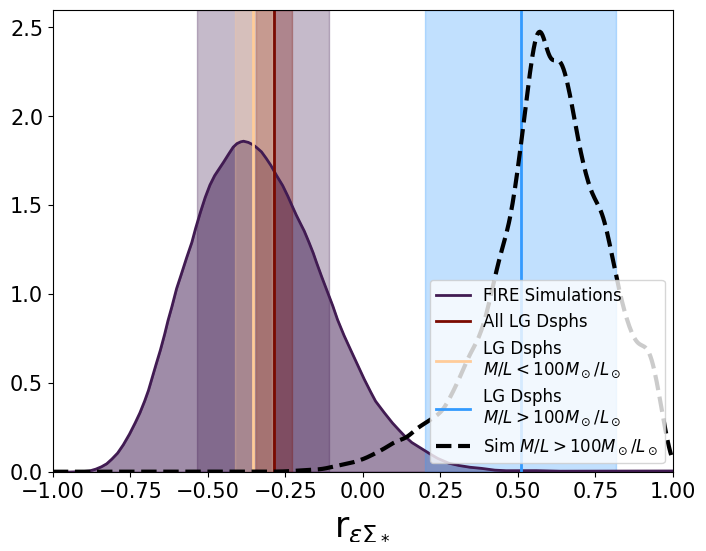

In [53]:

f, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.set_xlabel(r'r$_{\epsilon\Sigma_*}$', fontsize=25)
ax.tick_params(which='both', labelsize=15)
ax.set_xlim([-1, 1])

ax.axvspan(FIRE[0] - FIRE[1], FIRE[0] + FIRE[1], color=FIRE[2], alpha=.3)
ax.plot(FIRE_x, FIRE_y, color=FIRE[2], linewidth=2, label=FIRE[3])
ax.fill_between(FIRE_x, [0] * len(FIRE_x), FIRE_y, color=FIRE[2], alpha=.5)
for obs in [LGall, LGbright, LGdim]:
    ax.axvline(obs[0], color=obs[2], linewidth=2, label=obs[3])
    ax.axvspan(obs[0] - obs[1], obs[0] + obs[1], color=obs[2], alpha=.3)

# density = stats.gaussian_kde(r_dist_b)
# ax.plot(xbins, density(xbins), c='k', linewidth=3, label=r'Sim $M/L<100M_\odot/L_\odot$')
density = stats.gaussian_kde(r_dist_d)
ax.plot(xbins, density(xbins), c='k', linewidth=3, linestyle='--', label=r'Sim $M/L>100M_\odot/L_\odot$')
ax.set_ylim(bottom=0)
ax.legend(loc='lower right', prop={'size': 12})
# plt.show()
f.savefig('CorrelationTesting/Correlation.DimSplit.png', bbox_inches='tight', pad_inches=.1)


nb, nd = 0, 0
for i in np.arange(len(ellb)):
    if np.isfinite(ellb[i]) and np.isfinite(sbb[i]): nb += 1
for i in np.arange(len(elld)):
    if np.isfinite(elld[i]) and np.isfinite(sbd[i]): nd += 1
print(f'Bright: {nb} - {np.mean(r_dist_b)}')
print(f'Dim: {nd} - {np.mean(r_dist_d)}')

dict_keys(['Mvir', 'Mstar'])
dict_keys(['Mvir', 'Mstar'])
dict_keys(['Mvir', 'Mstar'])
dict_keys(['Mvir', 'Mstar'])
dict_keys(['Mvir', 'Mstar'])
dict_keys(['Mvir', 'Mstar'])
dict_keys(['Mvir', 'Mstar'])


2025-05-08 15:05:09,375 - matplotlib.mathtext - INFO - Substituting symbol S from STIXNonUnicode
2025-05-08 15:05:09,379 - matplotlib.mathtext - INFO - Substituting symbol S from STIXNonUnicode
2025-05-08 15:05:09,427 - matplotlib.mathtext - INFO - Substituting symbol S from STIXNonUnicode
2025-05-08 15:05:09,430 - matplotlib.mathtext - INFO - Substituting symbol S from STIXNonUnicode
2025-05-08 15:05:09,593 - matplotlib.mathtext - INFO - Substituting symbol S from STIXNonUnicode
2025-05-08 15:05:09,596 - matplotlib.mathtext - INFO - Substituting symbol S from STIXNonUnicode
2025-05-08 15:05:09,688 - matplotlib.mathtext - INFO - Substituting symbol S from STIXNonUnicode
2025-05-08 15:05:09,692 - matplotlib.mathtext - INFO - Substituting symbol S from STIXNonUnicode


FileNotFoundError: [Errno 2] No such file or directory: '/CorrelationTesting/CorrVsMaster.png'

2025-05-08 15:05:10,904 - matplotlib.mathtext - INFO - Substituting symbol S from STIXNonUnicode
2025-05-08 15:05:10,907 - matplotlib.mathtext - INFO - Substituting symbol S from STIXNonUnicode
2025-05-08 15:05:10,980 - matplotlib.mathtext - INFO - Substituting symbol S from STIXNonUnicode
2025-05-08 15:05:10,983 - matplotlib.mathtext - INFO - Substituting symbol S from STIXNonUnicode


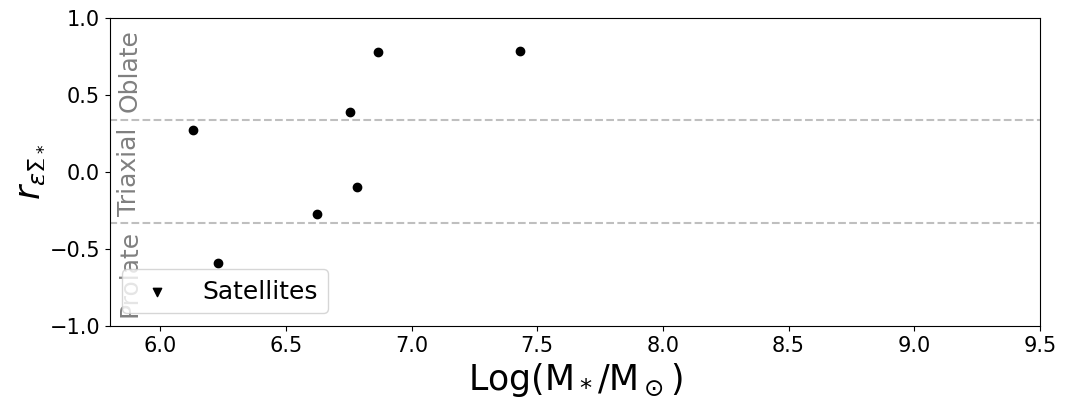

2025-05-08 15:05:11,183 - matplotlib.mathtext - INFO - Substituting symbol S from STIXNonUnicode
2025-05-08 15:05:11,187 - matplotlib.mathtext - INFO - Substituting symbol S from STIXNonUnicode


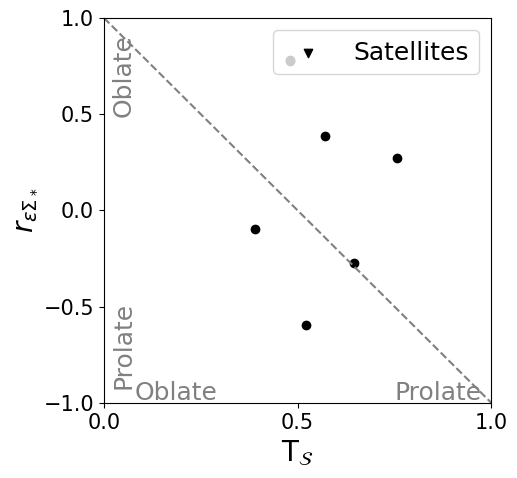

2025-05-08 15:05:11,357 - matplotlib.mathtext - INFO - Substituting symbol S from STIXNonUnicode
2025-05-08 15:05:11,361 - matplotlib.mathtext - INFO - Substituting symbol S from STIXNonUnicode


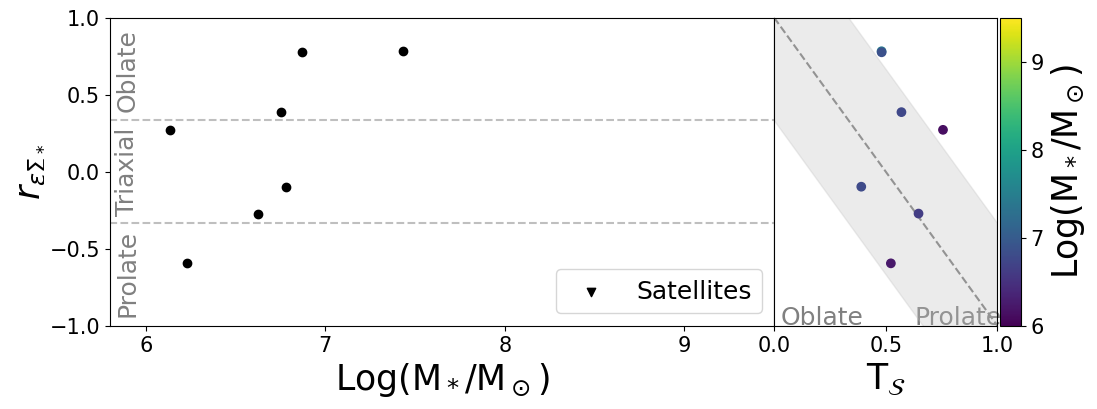

In [60]:

# Individual Correlations from diff orientations

def T(ba, ca):
    return ((1 - ba ** 2) / (1 - ca ** 2))


PlotDict = ShapeData
r_dist_c, mass_c, triax_c = [], [], []
r_dist_s, mass_s, triax_s = [], [], []
for sim in ProfData:
    for halo in SimInfo[sim]['goodhalos']:
        halo, ell, sb = str(halo), [], []
        for angle in ProfData[sim][halo]:
            ell.append(1 - PlotDict[sim][halo][angle]['b/a'])
            sb.append(ProfData[sim][halo][angle]['Sigma0'])
        Reff = ProfData[sim][str(halo)]['x000y000']['Reff']
        b = float(MorphData[sim][str(halo)]['ba_smooth'](Reff))
        c = float(MorphData[sim][str(halo)]['ca_smooth'](Reff))
        r = correlation(ell, sb)
        m = np.log10(MassData[sim][halo]['Mstar'])
        t = T(b, c)
        if (sim, halo) in sats:
            r_dist_s.append(r)
            mass_s.append(m)
            triax_s.append(t)
        else:
            r_dist_c.append(r)
            mass_c.append(m)
            triax_c.append(t)

# Corr vs Mstar
f, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.set_xlim([5.8, 9.5])
ax.set_ylim([-1, 1])
ax.set_yticks([-1, -.5, 0, .5, 1])
ax.set_xlabel(r'Log(M$_*$/M$_\odot$)', fontsize=25)
ax.set_ylabel(r'$r_{\epsilon\Sigma_*}$', fontsize=25)
ax.plot([4, 9.5], [-1 / 3, -1 / 3], c='.75', linestyle='--', zorder=0)
ax.plot([4, 9.5], [1 / 3, 1 / 3], c='.75', linestyle='--', zorder=0)
ax.tick_params(which='both', labelsize=15)
ax.text(5.83, -.66, 'Prolate', fontsize=18, rotation='vertical', verticalalignment='center', c='.5')
ax.text(5.83, 0, 'Triaxial', fontsize=18, rotation='vertical', verticalalignment='center', c='.5')
ax.text(5.83, .66, 'Oblate', fontsize=18, rotation='vertical', verticalalignment='center', c='.5')

ax.scatter(mass_c, r_dist_c, c='k')
ax.scatter(mass_s, r_dist_s, c='k', marker='v', label='Satellites')

ax.legend(loc='lower left', prop={'size': 18})
f.savefig('CorrelationTesting/CorrVsMstar.png', bbox_inches='tight', pad_inches=.1)


# Corr vs Triax
f, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.set_xlim([0, 1])
ax.set_ylim([-1, 1])
ax.set_yticks([-1, -.5, 0, .5, 1])
ax.set_xticks([0, .5, 1])
# ax.fill_between([0,1],[-.1,.9],[.1,1.1],color='0.75',alpha=.3)
ax.plot([0, 1], [1, -1], c='0.5', linestyle='--')
ax.set_xlabel(r'T$_\mathcal{S}$', fontsize=20)
ax.set_ylabel(r'$r_{\epsilon\Sigma_*}$', fontsize=20)
ax.tick_params(which='both', labelsize=15)
ax.text(.08, -.95, 'Oblate', fontsize=18, verticalalignment='center', c='.5', zorder=0)
ax.text(.75, -.95, 'Prolate', fontsize=18, verticalalignment='center', c='.5', zorder=0)
ax.text(.02, -.7, 'Prolate', fontsize=18, rotation='vertical', verticalalignment='center', c='.5', zorder=0)
ax.text(.02, .7, 'Oblate', fontsize=18, rotation='vertical', verticalalignment='center', c='.5', zorder=0)

ax.scatter(triax_c, r_dist_c, c='k')
ax.scatter(triax_s, r_dist_s, c='k', marker='v', label='Satellites')

ax.legend(loc='upper right', prop={'size': 18})
f.savefig('CorrelationTesting/CorrVsTriax.png', bbox_inches='tight', pad_inches=.1)


# Corr Vs Master
f, ax = plt.subplot_mosaic([['A', 'A', 'A', 'A', 'A', 'B', 'B']], figsize=(12, 4))
plt.subplots_adjust(hspace=0, wspace=0)

for i in ['A', 'B']:
    ax[i].set_ylim([-1, 1])
    ax[i].tick_params(which='both', labelsize=15)
ax['A'].set_ylabel(r'$r_{\epsilon\Sigma_*}$', fontsize=25)
ax['A'].set_xlabel(r'Log(M$_*$/M$_\odot$)', fontsize=25)
ax['B'].set_xlabel(r'T$_\mathcal{S}$', fontsize=25)
ax['A'].set_xlim([5.8, 9.5])
ax['A'].set_xticks([6, 7, 8, 9])
ax['B'].set_xlim([0, 1])
ax['B'].set_xticks([0, .5, 1])
ax['A'].set_yticks([-1, -.5, 0, .5, 1])
ax['B'].set_yticks([])

ax['A'].plot([4, 9.5], [-1 / 3, -1 / 3], c='.75', linestyle='--', zorder=0)
ax['A'].plot([4, 9.5], [1 / 3, 1 / 3], c='.75', linestyle='--', zorder=0)
ax['A'].text(5.83, -.66, 'Prolate', fontsize=18, rotation='vertical', verticalalignment='center', c='.5')
ax['A'].text(5.83, 0, 'Triaxial', fontsize=18, rotation='vertical', verticalalignment='center', c='.5')
ax['A'].text(5.83, .66, 'Oblate', fontsize=18, rotation='vertical', verticalalignment='center', c='.5')
ax['A'].scatter(mass_c, r_dist_c, c='k')
ax['A'].scatter(mass_s, r_dist_s, c='k', marker='v', label='Satellites')
ax['A'].legend(loc='lower right', prop={'size': 18})

ax['B'].fill_between([0, 1], [1 / 3, -5 / 3], [5 / 3, -1 / 3], color='0.75', alpha=.3)
ax['B'].plot([0, 1], [1, -1], c='0.5', linestyle='--', zorder=0)
ax['B'].text(.03, -.95, 'Oblate', fontsize=18, verticalalignment='center', c='.5', zorder=0)
ax['B'].text(.63, -.95, 'Prolate', fontsize=18, verticalalignment='center', c='.5', zorder=0)
norm = plt.Normalize(6, 9.5)
p = ax['B'].scatter(triax_c, r_dist_c, c=mass_c, cmap='viridis', norm=norm)
ax['B'].scatter(triax_s, r_dist_s, c=mass_s, cmap='viridis', norm=norm, marker='v', label='Satellites')
c = f.colorbar(p, ax=ax['B'], pad=0.01, aspect=15)
c.set_label(r'Log(M$_*$/M$_\odot$)', fontsize=25)
c.ax.tick_params(labelsize=15)
c.set_ticks([6, 7, 8, 9])

f.savefig('CorrelationTesting/CorrVsMaster.png', bbox_inches='tight', pad_inches=.1)


In [61]:
triax_c

[0.4810407719711506,
 0.48142242244603883,
 0.6466807083898712,
 0.390156919141208,
 0.5701347216830575,
 0.7562874301498558,
 0.5227609014207265]